### Baseline Text Classification Model for All the News Dataset
Goal: Predict the classification of news articles based on their section labels. For our baseline model, we will start with a dataset of 25K articles distributed across five categories: business, sports, technology, healthcare, and movies.

### Import librarires

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc
import spacy
from sklearn.metrics import f1_score
import sklearn

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/curtispond/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/curtispond/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Print the version of Sklearn
print(sklearn.__version__)

1.1.1


### Load and inspect the data

In [3]:
df = pd.read_csv('./data/all-the-news-100k.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   date            100000 non-null  object
 1   year            100000 non-null  int64 
 2   month           100000 non-null  object
 3   day             100000 non-null  int64 
 4   title           100000 non-null  object
 5   article         100000 non-null  object
 6   section         100000 non-null  object
 7   publication     100000 non-null  object
 8   word_count      100000 non-null  int64 
 9   char_count      100000 non-null  int64 
 10  sentence_count  100000 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 8.4+ MB


In [4]:
# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.head()

,date,year,month,day,title,article,section,publication,word_count,char_count,sentence_count
0,2019-06-17 00:00:00,2019,Jun,17,"ECB's Coeure: If we decide to cut rates, we'd ...","BERLIN, June 17 (Reuters) - ECB board member B...",financials,Reuters,133,654,4
1,2018-05-02 17:09:00,2018,May,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice,1810,8506,84
2,2019-06-23 00:00:00,2019,Jun,23,Hudson's Bay's chairman's buyout bid pits reta...,(Reuters) - The success of Hudson’s Bay Co Exe...,business,Reuters,890,4428,33
3,2018-12-28 00:00:00,2018,Dec,28,Wells Fargo to pay $575 million in settlement ...,NEW YORK (Reuters) - Wells Fargo & Co (WFC.N) ...,business,Reuters,405,2007,13
4,2019-05-21 00:00:00,2019,May,21,Factbox: Investments by automakers in the U.S....,(Reuters) - Major automakers have announced a ...,business,Reuters,954,4849,42


In [6]:
# How many null values are there in each column?
df.isnull().sum()

date              0
year              0
month             0
day               0
title             0
article           0
section           0
publication       0
word_count        0
char_count        0
sentence_count    0
dtype: int64

<AxesSubplot:title={'center':'Artile Count by Section'}>

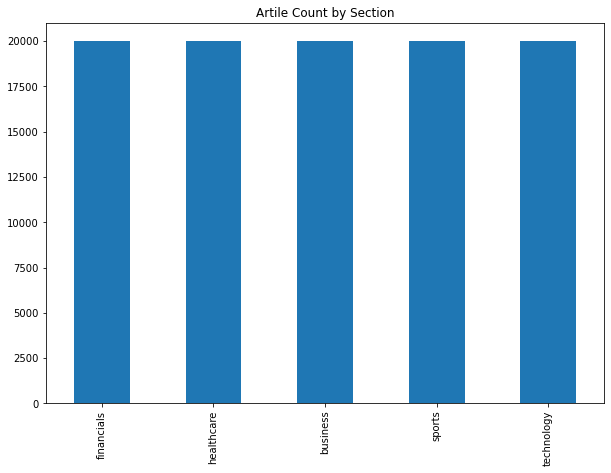

In [7]:
# Show the number of articles in each section
df['section'].value_counts()[:20].plot(kind='bar', figsize=(10,7), title='Artile Count by Section')

In [8]:
# Rename financials, business, and sports to other
df['section'] = df['section'].replace(['financials', 'business', 'sports'], 'other')
df.head()

,date,year,month,day,title,article,section,publication,word_count,char_count,sentence_count
0,2019-06-17 00:00:00,2019,Jun,17,"ECB's Coeure: If we decide to cut rates, we'd ...","BERLIN, June 17 (Reuters) - ECB board member B...",other,Reuters,133,654,4
1,2018-05-02 17:09:00,2018,May,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice,1810,8506,84
2,2019-06-23 00:00:00,2019,Jun,23,Hudson's Bay's chairman's buyout bid pits reta...,(Reuters) - The success of Hudson’s Bay Co Exe...,other,Reuters,890,4428,33
3,2018-12-28 00:00:00,2018,Dec,28,Wells Fargo to pay $575 million in settlement ...,NEW YORK (Reuters) - Wells Fargo & Co (WFC.N) ...,other,Reuters,405,2007,13
4,2019-05-21 00:00:00,2019,May,21,Factbox: Investments by automakers in the U.S....,(Reuters) - Major automakers have announced a ...,other,Reuters,954,4849,42


In [9]:
# show an article from the technology section
df[df['section'] == 'healthcare']['article']

1        If only every day could be like this. You can’...
62       As a psychologist, I often hear stories about ...
68        In late March, the Environmental Protection A...
70       When Mel Cohen first began injecting estrogen,...
72        Five men stand behind a two-way mirror, polic...
                               ...                        
91343    June 19 (Reuters) - EURONEXT: * FOLLOWING PRIV...
91344    Jan 31 (Reuters) - BASTIDE GROUPE: * ANNOUNCES...
91345    May 2 (Reuters) - FONET BILGI TEKNOLOJILERI: *...
91348    Dec 14 (Reuters) - reMYND: * REMYND-UNDER AGRE...
91350    Oct 21 (Reuters) - Guangdong Jiaying Pharmaceu...
Name: article, Length: 20000, dtype: object

In [10]:
# Show an article from technology section
df[df['section'] == 'healthcare']['article'].iloc[14]

"For the past couple days Donald Trump and his allies have been attempting to twist the arms of Republicans in Congress to vote for the American Health Care Act (AHCA), a piece of legislation that would water down the Obama-era Affordable Care Act (ACA).\xa0 The AHCA\xa0is widely hated—Democrats dislike it because it would weaken the ACA, and many conservatives don't think it goes far enough to repeal the current law. So\xa0Trump has been using a combination of charm and threats to sell the AHCA\xa0right-wing House members who might not like the bill, but like opposing Trump even less. It's a tough sales pitch even for a master persuader—if 22 Republicans are against the bill\xa0it will go down, and as of Wednesday afternoon it looked like it was going down big\xa0league thanks to conservative opposition:\xa0\xa0 That tweet is from a spokesperson for the Freedom Caucus, a group of hardline right-wingers who have achieved an outsized amount of power because the Republican leadership nee

<AxesSubplot:title={'center':'Article Count by Section'}>

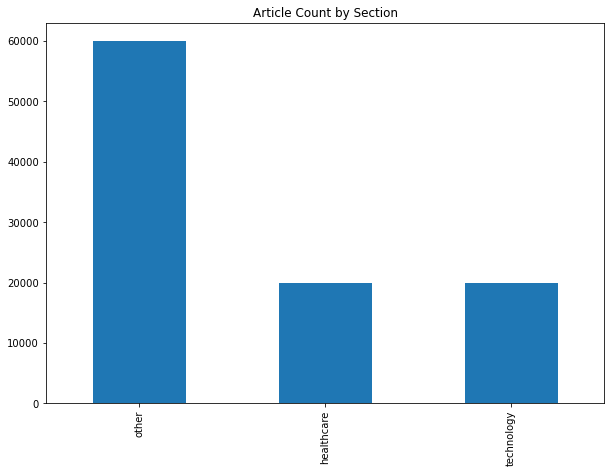

In [11]:
# Show the number of articles in each section
df['section'].value_counts()[:20].plot(kind='bar', figsize=(10,7), title='Article Count by Section')

In [12]:
# Drop random sample of 40000 articles from other section
df = df.drop(df[df['section'] == 'other'].sample(40000).index)
df.head()

,date,year,month,day,title,article,section,publication,word_count,char_count,sentence_count
0,2019-06-17 00:00:00,2019,Jun,17,"ECB's Coeure: If we decide to cut rates, we'd ...","BERLIN, June 17 (Reuters) - ECB board member B...",other,Reuters,133,654,4
1,2018-05-02 17:09:00,2018,May,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice,1810,8506,84
9,2019-06-27 00:00:00,2019,Jun,27,FCC probes whether Sinclair misled agency duri...,WASHINGTON (Reuters) - Shares in Sinclair Broa...,other,Reuters,469,2342,19
10,2016-08-18 16:45:00,2016,Aug,18,U.S. Relay Team Successfully Appeals DQ After ...,"Ryan Lochte hijinks aside, the weirdest thing ...",other,Vice,287,1280,19
12,2019-06-20 00:00:00,2019,Jun,20,"Hungary has no evidence of Huawei threat, plan...",BUDAPEST (Reuters) - Hungary has no evidence t...,technology,Reuters,613,3139,24


In [13]:
df.shape

(60000, 11)

<AxesSubplot:title={'center':'Number of articles in each section'}>

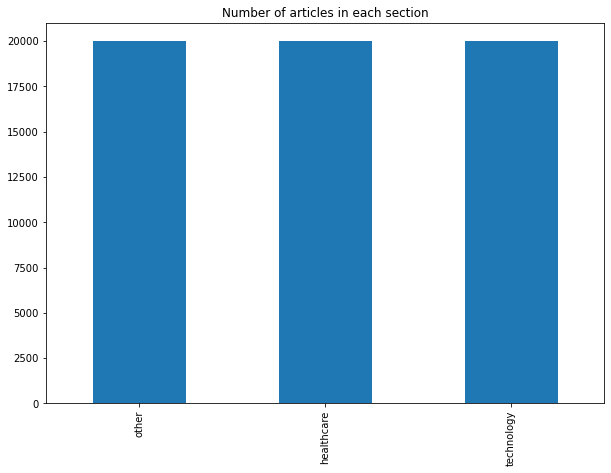

In [14]:
# Show the number of articles in each section
df['section'].value_counts()[:20].plot(kind='bar', figsize=(10,7), title='Number of articles in each section')

### Text Classification process for baseline model

1. Ensure the dataset is as balanced as possible (already done in dataset preparation)
2. Process the data (remove stop words, punctuation, etc.)
3. Create a Bag of Words feature to turn text into numbers
3. Create training and test set
4. Run some models and predictions

### Prepare data for modeling on df dataset

In [15]:
#Convert the section column into categorical values
target_section = df['section'].unique()
print(target_section)

['other' 'healthcare' 'technology']


In [16]:
# Convert the section column into numerical values
df['sectionId'] = df['section'].factorize()[0]
df.head()

,date,year,month,day,title,article,section,publication,word_count,char_count,sentence_count,sectionId
0,2019-06-17 00:00:00,2019,Jun,17,"ECB's Coeure: If we decide to cut rates, we'd ...","BERLIN, June 17 (Reuters) - ECB board member B...",other,Reuters,133,654,4,0
1,2018-05-02 17:09:00,2018,May,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice,1810,8506,84,1
9,2019-06-27 00:00:00,2019,Jun,27,FCC probes whether Sinclair misled agency duri...,WASHINGTON (Reuters) - Shares in Sinclair Broa...,other,Reuters,469,2342,19,0
10,2016-08-18 16:45:00,2016,Aug,18,U.S. Relay Team Successfully Appeals DQ After ...,"Ryan Lochte hijinks aside, the weirdest thing ...",other,Vice,287,1280,19,0
12,2019-06-20 00:00:00,2019,Jun,20,"Hungary has no evidence of Huawei threat, plan...",BUDAPEST (Reuters) - Hungary has no evidence t...,technology,Reuters,613,3139,24,2


In [17]:
# Show the category's name and id
category_id_df = df[['section', 'sectionId']].drop_duplicates().sort_values('sectionId')
category_id_df

,section,sectionId
0,other,0
1,healthcare,1
12,technology,2


In [18]:
# Show a technology article
df[df['section'] == 'technology'].head(1)


,date,year,month,day,title,article,section,publication,word_count,char_count,sentence_count,sectionId
12,2019-06-20,2019,Jun,20,"Hungary has no evidence of Huawei threat, plan...",BUDAPEST (Reuters) - Hungary has no evidence t...,technology,Reuters,613,3139,24,2


<AxesSubplot:title={'center':'Target Sections and their Corresponding Ids'}, xlabel='section,sectionId'>

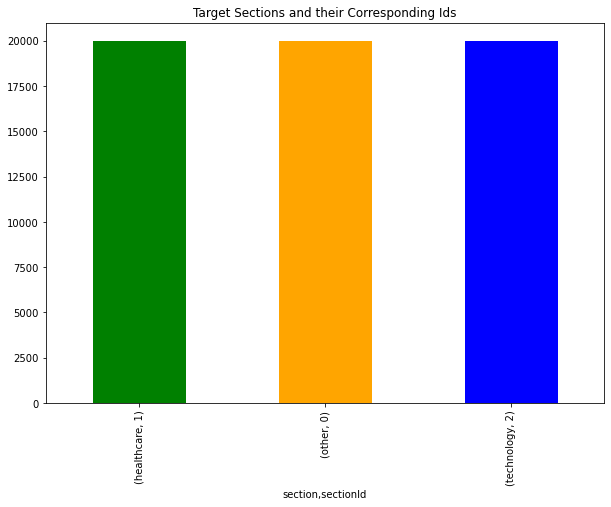

In [19]:
# Visualize the number of articles in each section
df.groupby('section').sectionId.value_counts().plot(kind='bar', \
    color= ["green", "orange", "blue", "yellow", "brown"], figsize=(10,7), title='Target Sections and their Corresponding Ids')

### Clean the article text

In [20]:
# Use NLTK to remove stopwords
stop = stopwords.words('english')

df['clean_article'] = df['article'].map(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [21]:
import re
import string
def process_text(text):
    text = str(text).lower()
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", " ", text
    )
    text = " ".join(text.split())
    return text

df['text'] = df['clean_article'].apply(process_text)

In [22]:
df.head()

,date,year,month,day,title,article,section,publication,word_count,char_count,sentence_count,sectionId,clean_article,text
0,2019-06-17 00:00:00,2019,Jun,17,"ECB's Coeure: If we decide to cut rates, we'd ...","BERLIN, June 17 (Reuters) - ECB board member B...",other,Reuters,133,654,4,0,"BERLIN, June 17 (Reuters) - ECB board member B...",berlin june 17 reuters ecb board member benoit...
1,2018-05-02 17:09:00,2018,May,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice,1810,8506,84,1,If every day could like this. You can’t put fi...,if every day could like this you can’t put fin...
9,2019-06-27 00:00:00,2019,Jun,27,FCC probes whether Sinclair misled agency duri...,WASHINGTON (Reuters) - Shares in Sinclair Broa...,other,Reuters,469,2342,19,0,WASHINGTON (Reuters) - Shares Sinclair Broadca...,washington reuters shares sinclair broadcast g...
10,2016-08-18 16:45:00,2016,Aug,18,U.S. Relay Team Successfully Appeals DQ After ...,"Ryan Lochte hijinks aside, the weirdest thing ...",other,Vice,287,1280,19,0,"Ryan Lochte hijinks aside, weirdest thing happ...",ryan lochte hijinks aside weirdest thing happe...
12,2019-06-20 00:00:00,2019,Jun,20,"Hungary has no evidence of Huawei threat, plan...",BUDAPEST (Reuters) - Hungary has no evidence t...,technology,Reuters,613,3139,24,2,BUDAPEST (Reuters) - Hungary evidence equipmen...,budapest reuters hungary evidence equipment ch...


In [23]:
# Show a technology article
df[df['section'] == 'technology']['text'].iloc[33]

'brussels reuters u s tech giant international business machines corp set secure unconditional eu approval 34 billion bid software company red hat people familiar matter said wednesday ibm seeking expand subscription based software offerings via deal biggest date counter slowing software sales waning demand mainframe servers it would also help catch amazon alphabet inc microsoft fast growing cloud computing business the european commission scheduled decide deal june 27 ibm declined comment founded 1993 red hat specializes linux operating systems popular type open source software alternative proprietary software made microsoft u s regulatory authorities gave green light deal last month without demanding concessions reporting foo yun chee editing alissa de carbonnel elaine hardcastle'

### Build models and make predictions

In [24]:
# Split the data into training and test sets
target = df['sectionId']
df_train, df_test = train_test_split(df, test_size=0.20, stratify=target)

In [25]:
vec = CountVectorizer()

X_train = vec.fit_transform(df_train.text)
X_test = vec.transform(df_test.text)

y_train = df_train.sectionId
y_test = df_test.sectionId

In [ ]:
# Create a pickle file for the CountVectorizer
import pickle5 as pickle
pickle.dump(vec, open('vectorizer_021823.pkl', 'wb'))

In [26]:
# What version of NLTK
import nltk
print(nltk.__version__)

3.8.1


##### Logistic Regression: F1 - .92%

In [27]:
# Train a logistic regression model
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/fastai/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Pickle the model
pickle.dump(lr, open('lr_021823.pkl', 'wb'))

In [28]:
# Predict the test set results
y_pred = lr.predict(X_test)

In [29]:
# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.9215


In [30]:
# Show precision, recall, and f1-score
print(classification_report(y_test, y_pred, target_names=df['section'].unique()))

              precision    recall  f1-score   support

       other       0.90      0.89      0.90      4000
  healthcare       0.94      0.94      0.94      4000
  technology       0.92      0.93      0.92      4000

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



In [31]:
# Overall F1 score
print("F1 score: ", f1_score(y_test, y_pred, average='weighted'))

F1 score:  0.9214406721754084


Test sentences

0. Other: Sitting across from Jimmy Fallon on “The Tonight Show,” Paris Hilton, wearing a sparkling neon green turtleneck dress and a high ponytail, looked at a picture of a glum cartoon ape and said it “reminds me of me.” The audience laughed. It did not look like her at all.
1. Healthcare: Plans are moving forward at the US Department of Health and Human Services to prepare for the end of the nation’s Covid-19 public health emergency declaration in May.
2. As Apple looks beyond China to secure crucial supply chains strained by Covid lockdowns and threatened by rising geopolitical tension, India has emerged as an attractive potential alternative to the world’s second largest economy.